In [1]:
import numpy as np
import matplotlib.pyplot as plt

import copy
import itertools
from typing import List, Tuple, Dict

# Set random seed
np.random.seed(2022)

In [2]:
# Fitness function
def tsp_fitness_func(chromosome: np.array, map: np.array) -> float:
    """
    Fitness: An evaluator of each chromosome.
    The fitness function return a fitness score to each chromosome.
    """

    # Check for validation
    assert len(chromosome) == len(map), 'Wrong Matrix!'
    city_num = len(map)
    # All city must be visited.
    # Can not visit one city twice.
    if set(chromosome) != set(i for i in range(city_num)):
        return 0

    # Calculate ordered distance
    distance = 0
    for i in range(city_num - 1):
        distance += map[chromosome[i]][chromosome[i + 1]]

    return distance


def roulette_wheel_prob(population: np.array, beta: float) -> np.array:
    """
    Calculating probability for roulette wheel selection.
    """
    score = []
    for i in range(len(population)):
        score.append(population[i]['score'])

    # (N,)
    score = np.array(score)
    avg_score = np.mean(score)
    if avg_score != 0:
        score = score / avg_score

    # (N,)
    return np.exp(-beta * score)


def roulette_wheel_selection(prob: np.array) -> np.array:
    """
    Parents: two selected chromosome for generating the next generation.
    The chromosome with higher fitness score has bigger chance being selected for reproduction.
    We take the cumsum of probabilities and select the first parent whose cumsum is greater than random number.
    """

    # (N,)
    c = np.cumsum(prob)
    r = sum(prob) * np.random.rand()
    # (M,)
    ind = np.argwhere(r <= c)

    return ind[0][0]


# Crossover
def one_point_crossover(parent1: np.array, parent2: np.array) -> Tuple:
    """
    Introduce randomness into the population by swapping parents' chromosomes.
    Randomly select a crossover point for a pair of parents and exchange the genes of parents.
    """
    child1 = copy.deepcopy(parent1)
    child2 = copy.deepcopy(parent2)

    # One-point crossover
    one_point_index = np.random.randint(1, len(parent1['gene'] - 1))

    child1['gene'] = np.concatenate((parent1['gene'][: one_point_index], parent2['gene'][one_point_index:]))
    child2['gene'] = np.concatenate((parent2['gene'][: one_point_index], parent1['gene'][one_point_index:]))

    return child1, child2


# Mutation
def swap_mutation(chromosome: np.array, mu: float, gene_num: int) -> np.array:
    """
    The genes in a new formed offspring subject to a mutation with a low probability.
    Mutation maintains diversity within a population preventing the population from early convergence.

    Args:
        chromosome: Child chromosome.
        mu: Mutation rate. % of gene to be modified.
        gene_num: number of cities.
    """
    y = copy.deepcopy(chromosome)

    flag = np.random.rand(*chromosome['gene'].shape) <= mu
    ind = np.argwhere(flag)[:, 0]

    while len(ind) % 2 != 0:
        temp = np.random.randint(gene_num)
        if temp not in ind:
            ind = np.append(ind, temp)

    swap_dict = np.random.choice(len(ind), len(ind), replace=False).reshape(-1, 2)
    for i in swap_dict:
        temp = y['gene'][ind[i[0]]]
        y['gene'][ind[i[0]]] = y['gene'][ind[i[1]]]
        y['gene'][ind[i[1]]] = temp

    return y


def sort_chromosome(population: np.array, population_size: int) -> np.array:
    """
    Bubble sorting the population and offspring in every iteration to get best fit individuals at top.
    Add new formed offsprings to the population.
    The chromosomes with lower fitness scores are deleted from the population as the offspring formed.
    """
    n = len(population)

    for i in range(n - 1):
        for j in range(0, n - i - 1):
            if population[j]['score'] < population[j + 1]['score']:
                population[j], population[j + 1] = population[j + 1], population[j]

    return dict(itertools.islice(population.items(), population_size))


# Initial population
def binary_initialization(population_size: int, gene_num: int, map: np.array) -> Dict:
    """
    Gene: an element of the problem.
    Individual (chromosome): a solution that satisfies restrictions.
    Population: a set of possible chromosomes.
    """

    population = {}
    # Each individual has position(chromosomes) and cost
    for i in range(population_size):
        population[i] = {'gene': None, 'score': None}

    # First generation
    for i in range(population_size):
        # Randomly initialize chromosomes
        population[i]['gene'] = np.random.randint(gene_num + 1, size=gene_num)
        population[i]['gene'] = np.random.choice(gene_num, gene_num, replace=False)

        # Calculate fitness scores
        population[i]['score'] = tsp_fitness_func(population[i]['gene'], map)

    return population

In [3]:
def tsp_evaluation(population_size: int,
                   gene_num: int,
                   epoch: int,
                   beta: float,
                   mu: float,
                   map: np.array):
    population = binary_initialization(population_size,
                                       gene_num,
                                       map)

    # Define best chromosome in the first generation
    # best_score = np.inf
    # best_chromosome = None
    #
    # for i in range(population_size):
    #     if population[i]['score'] < best_score:
    #         best_chromosome = copy.deepcopy(population[i])
    #         best_score = population[i]['score']

    # Find best chromosome during iteration
    best_score_list = []
    best_chromosome_list = []

    # Main loop
    for iteration in range(epoch):
        prob = roulette_wheel_prob(population, beta)

        for _ in range(population_size // 2):
            # Roulette wheel selection
            p1 = population[roulette_wheel_selection(prob)]
            p2 = population[roulette_wheel_selection(prob)]

            # crossover two parents
            c1, c2 = one_point_crossover(p1, p2)

            # Perform mutation
            c1 = swap_mutation(c1, mu, gene_num)
            c2 = swap_mutation(c2, mu, gene_num)

            score_c1 = tsp_fitness_func(c1['gene'], map)
            score_c2 = tsp_fitness_func(c2['gene'], map)

            c1['score'] = score_c1
            c2['score'] = score_c2

            # best_score = max(score_c1, score_c2)
            # best_chromosome = copy.deepcopy(c1) if score_c1 > score_c2 else copy.deepcopy(c2)

            # Merge, Sort and Select
            population[len(population)] = c1
            population[len(population)] = c2

        # The algorithm is terminated when offspring are similar to the previous generation (converged).
        population = sort_chromosome(population, population_size)

        # Store best cost
        # best_score_list.append(best_score)
        # best_chromosome_list.append(best_chromosome)
        best_score_list.append(population[0]['score'])
        best_chromosome_list.append(population[0]['gene'])

        # Show generation information
        print('Iteration {}: Best Cost = {}: Best Solution = {}'.format(iteration,
                                                                        best_score_list[iteration],
                                                                        best_chromosome_list[iteration]))

    return best_score_list, best_chromosome_list

In [4]:
city_num = 10
map_random = np.random.randint(1, 100, size=(city_num, city_num))
map = ((map_random + map_random.T) / 2).astype(int)

best_cost, best_solution = tsp_evaluation(population_size=30,
                                          gene_num=city_num,
                                          epoch=5001,
                                          beta=1.0,
                                          mu=0.1,
                                          map=map)

Streaming output truncated to the last 5000 lines.
Iteration 1: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 2: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 3: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 4: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 5: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 6: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 7: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 8: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 9: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 10: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 11: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 12: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 13: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6 7 5 0]
Iteration 14: Best Cost = 554: Best Solution = [4 8 3 2 1 9 6

In [5]:
print(map)

[[93 40 32 40 83 56 45 25 43 59]
 [40 28 53 51 55 70 48 25 33 39]
 [32 53 17 89 54 59 70 13 44 52]
 [40 51 89 86 26 47 73 30 72 94]
 [83 55 54 26 78 37 52 52 77 28]
 [56 70 59 47 37 62 65 66 56 40]
 [45 48 70 73 52 65 65 40 67 62]
 [25 25 13 30 52 66 40 10 67 51]
 [43 33 44 72 77 56 67 67 92 48]
 [59 39 52 94 28 40 62 51 48 24]]


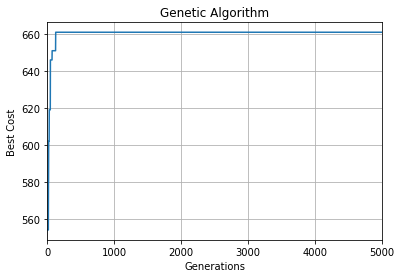

In [6]:
plt.plot(best_cost)
plt.xlim(0, 5001)
plt.xlabel('Generations')
plt.ylabel('Best Cost')
plt.title('Genetic Algorithm')
plt.grid(True)
plt.show()